In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
data_file = '/Users/nilvarshney/Google Drive/Machine Learning/PythonML/Datasets/creditcard.csv'
creditcard = pd.read_csv(data_file)

In [3]:
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Time and Amount data may not help. Let them drop them from the analysis.

In [4]:
creditcard.drop(['Time','Amount'],axis = 1,inplace=True)

Let first understand how much class data skewed

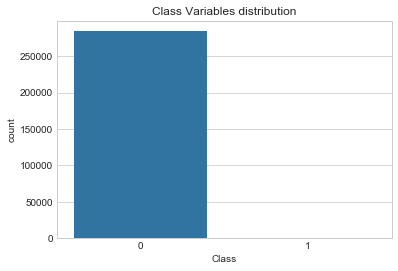

In [5]:
sns.countplot(data=creditcard,x = 'Class')
plt.title('Class Variables distribution')
plt.show()

In [6]:
creditcard.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

There are only 492 observations for abnormal transaction while 284315 observations for normal trasactions. Class is highly skewed. There are couple of sampling technique can be used.

https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis

I would prefer undersampling, in which I will pick randomly same no of observation from normal trasaction and will use it through analysis.

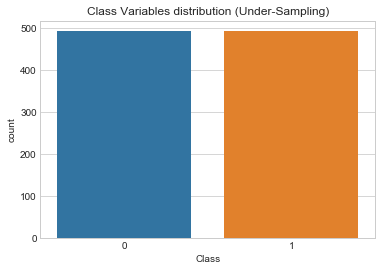

In [167]:
fraud_transaction_indexes = creditcard[creditcard['Class'] == 1].index.values
fraud_transaction_count = fraud_transaction_indexes.shape[0]
normal_transaction_indexes = np.random.choice(
    creditcard[creditcard['Class'] == 0].index.values,
    fraud_transaction_count,
    replace = False)

undersampling_indices = np.concatenate([fraud_transaction_indexes,normal_transaction_indexes])
undersampling_indices.reshape
undersample_creditcard = creditcard.iloc[undersampling_indices,:]

sns.countplot(data=undersample_creditcard,x = 'Class')
plt.title('Class Variables distribution (Under-Sampling)')
plt.show()

### Split Data in training and test dataset (70/30)

In [168]:
from sklearn.model_selection import train_test_split
#train_test_split()
X_undersample = undersample_creditcard.iloc[:,range(0,28)].values
y_undersample = undersample_creditcard['Class'].values

X = creditcard.iloc[:,range(0,28)].values
y = creditcard['Class'].values
type(X_undersample)

X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(
    X_undersample,y_undersample,test_size=0.3, random_state = 0)

X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(
    X,y,test_size=0.3, random_state = 0)



Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn import metrics

def logistic_reg(X_train,y_train, X_test, y_test):
    c = [0.001,0.01,0.1,1,10,100]
    for c_value in c:
        print("------------------------------------------")
        print('Logistic Regression using C value {}'.format(c_value))
        print("------------------------------------------")
        lin_log = LogisticRegression(C = c_value ).fit(X_train,y_train)
        log_csv = cross_val_score(lin_log,X_train,y_train,cv =5)
        print('Max Cross validation Score :\t{:.3}'.format(log_csv.max()))
        print('Min Cross validation Score :\t{:.3}'.format(log_csv.min()))
        print('Mean Cross validation Score :\t{:.3}'.format(log_csv.mean()))
        print('Training Samples Score :\t{:.3}'.format(lin_log.score(X_train,y_train)))
        print('Test Data Samples Score :\t{:.3}'.format(lin_log.score(X_test,y_test)))
        print('Recall Score :\t\t\t{:.3}'.format(metrics.recall_score(y_test, lin_log.predict(X_test))))
        print('Precision Score :\t\t{:.3}'.format(metrics.precision_score(y_test, lin_log.predict(X_test))))
        print('Average precision Score :\t{:.3}'.format(metrics.average_precision_score(
            y_test,lin_log.decision_function(X_test))))
        print('ROC AUC Score :\t\t\t{:.3}'.format(metrics.roc_auc_score(y_test,lin_log.decision_function(X_test))))
        print('F1 Score :\t\t\t{:.3}'.format(metrics.f1_score(y_test,lin_log.predict(X_test))))

    
logistic_reg(X_train_undersample, y_train_undersample,X_test_undersample,  y_test_undersample)

------------------------------------------
Logistic Regression using C value 0.001
------------------------------------------
Max Cross validation Score :	0.942
Min Cross validation Score :	0.855
Mean Cross validation Score :	0.892
Training Samples Score :	0.901
Test Data Samples Score :	0.899
Recall Score :			0.959
Precision Score :		0.855
Average precision Score :	0.983
ROC AUC Score :			0.98
F1 Score :			0.904
------------------------------------------
Logistic Regression using C value 0.01
------------------------------------------
Max Cross validation Score :	0.957
Min Cross validation Score :	0.906
Mean Cross validation Score :	0.933
Training Samples Score :	0.939
Test Data Samples Score :	0.939
Recall Score :			0.918
Precision Score :		0.957
Average precision Score :	0.985
ROC AUC Score :			0.982
F1 Score :			0.938
------------------------------------------
Logistic Regression using C value 0.1
------------------------------------------
Max Cross validation Score :	0.978
Min Cro

From above metrics C = 0.001 is best option to identify the fraud transaction but it act inversly with Normal trasaction which cause many normal trasaction will be marked Fraud. I would prefer balance approach which will give use good accuracy for Normal and Fraud transaction. Hence for further analysis I would prefer C = 0.01. 

In [170]:
print('******************************************************')
print('Actual Data Accuracy/ Metrics / Classification Report')
print('******************************************************')
logit_final = LogisticRegression(C=0.01).fit(X_train_undersample,y_train_undersample)
# predict result on test dataset of full data
y_predict = logit_final.predict(X_test_org)
conf_metrics = metrics.confusion_matrix(y_test_org,y_predict)
print('Correct Prediction \t{:.3f}%'.format(metrics.accuracy_score(y_test_org,y_predict)))
print('Correctly Predcited normal Transaction:\t{:.3}%'.format(conf_metrics[0][0]/(conf_metrics[0][0] + conf_metrics[0][1])))
print('Correctly Predcited Fraud Transaction:\t{:.3}%'.format(conf_metrics[1][1]/(conf_metrics[1][0] + conf_metrics[1][1])))
print(metrics.classification_report(y_test_org,y_predict))

******************************************************
Actual Data Accuracy/ Metrics / Classification Report
******************************************************
Correct Prediction 	0.960%
Correctly Predcited normal Transaction:	0.96%
Correctly Predcited Fraud Transaction:	0.918%
             precision    recall  f1-score   support

          0       1.00      0.96      0.98     85296
          1       0.04      0.92      0.07       147

avg / total       1.00      0.96      0.98     85443



******************************************************
ROC Curve / AUC Score
******************************************************
ROC AUC Score :	0.982


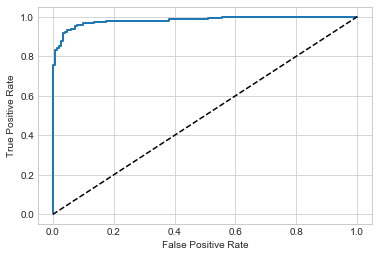

In [171]:
#X_train_undersample, y_train_undersample
print('******************************************************')
print('ROC Curve / AUC Score')
print('******************************************************')
y_score = logit_final.decision_function(X_test_undersample)
fpr,tpr, thresholds = metrics.roc_curve(y_test_undersample,y_score)
print('ROC AUC Score :\t{:.3}'.format(metrics.roc_auc_score(y_test_undersample,y_score)))


plt.plot(fpr,tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

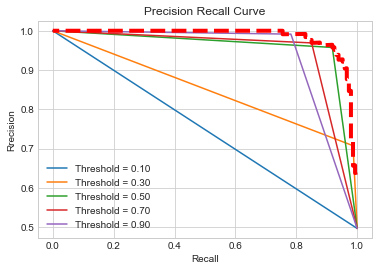

In [172]:
for threshold_value in [0.1,0.3,0.5,0.7,0.9]:
    precision, recall,threshold  = metrics.precision_recall_curve(
        y_test_undersample,logit_final.predict_proba(X_test_undersample)[:,1] > threshold_value)
    plt.plot(recall,precision,label= 'Threshold = %0.2f' %threshold_value)
    plt.legend()
    
precision, recall,threshold  = metrics.precision_recall_curve(
        y_test_undersample,logit_final.decision_function(X_test_undersample))
plt.plot(recall,precision,'r--',lw=4)
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Rrecision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower left")
plt.show()

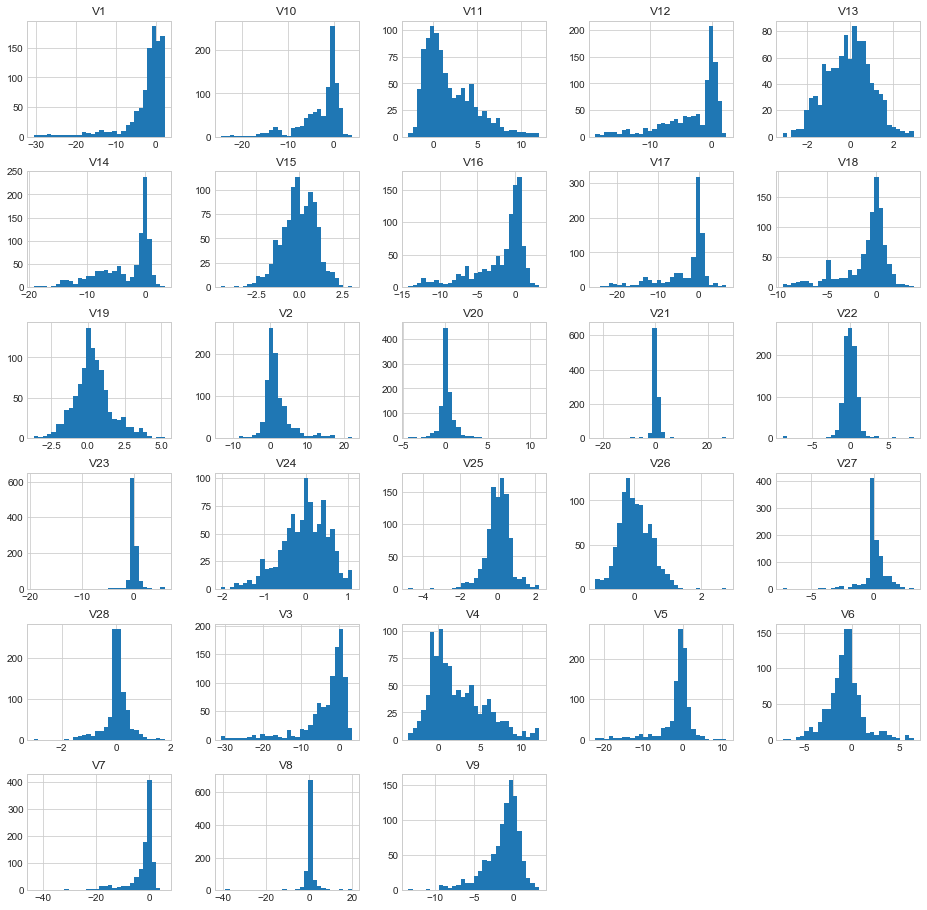

In [189]:
undersample_creditcard.iloc[:,range(0,28)].hist(figsize=(16,16),bins = 30)
plt.show()

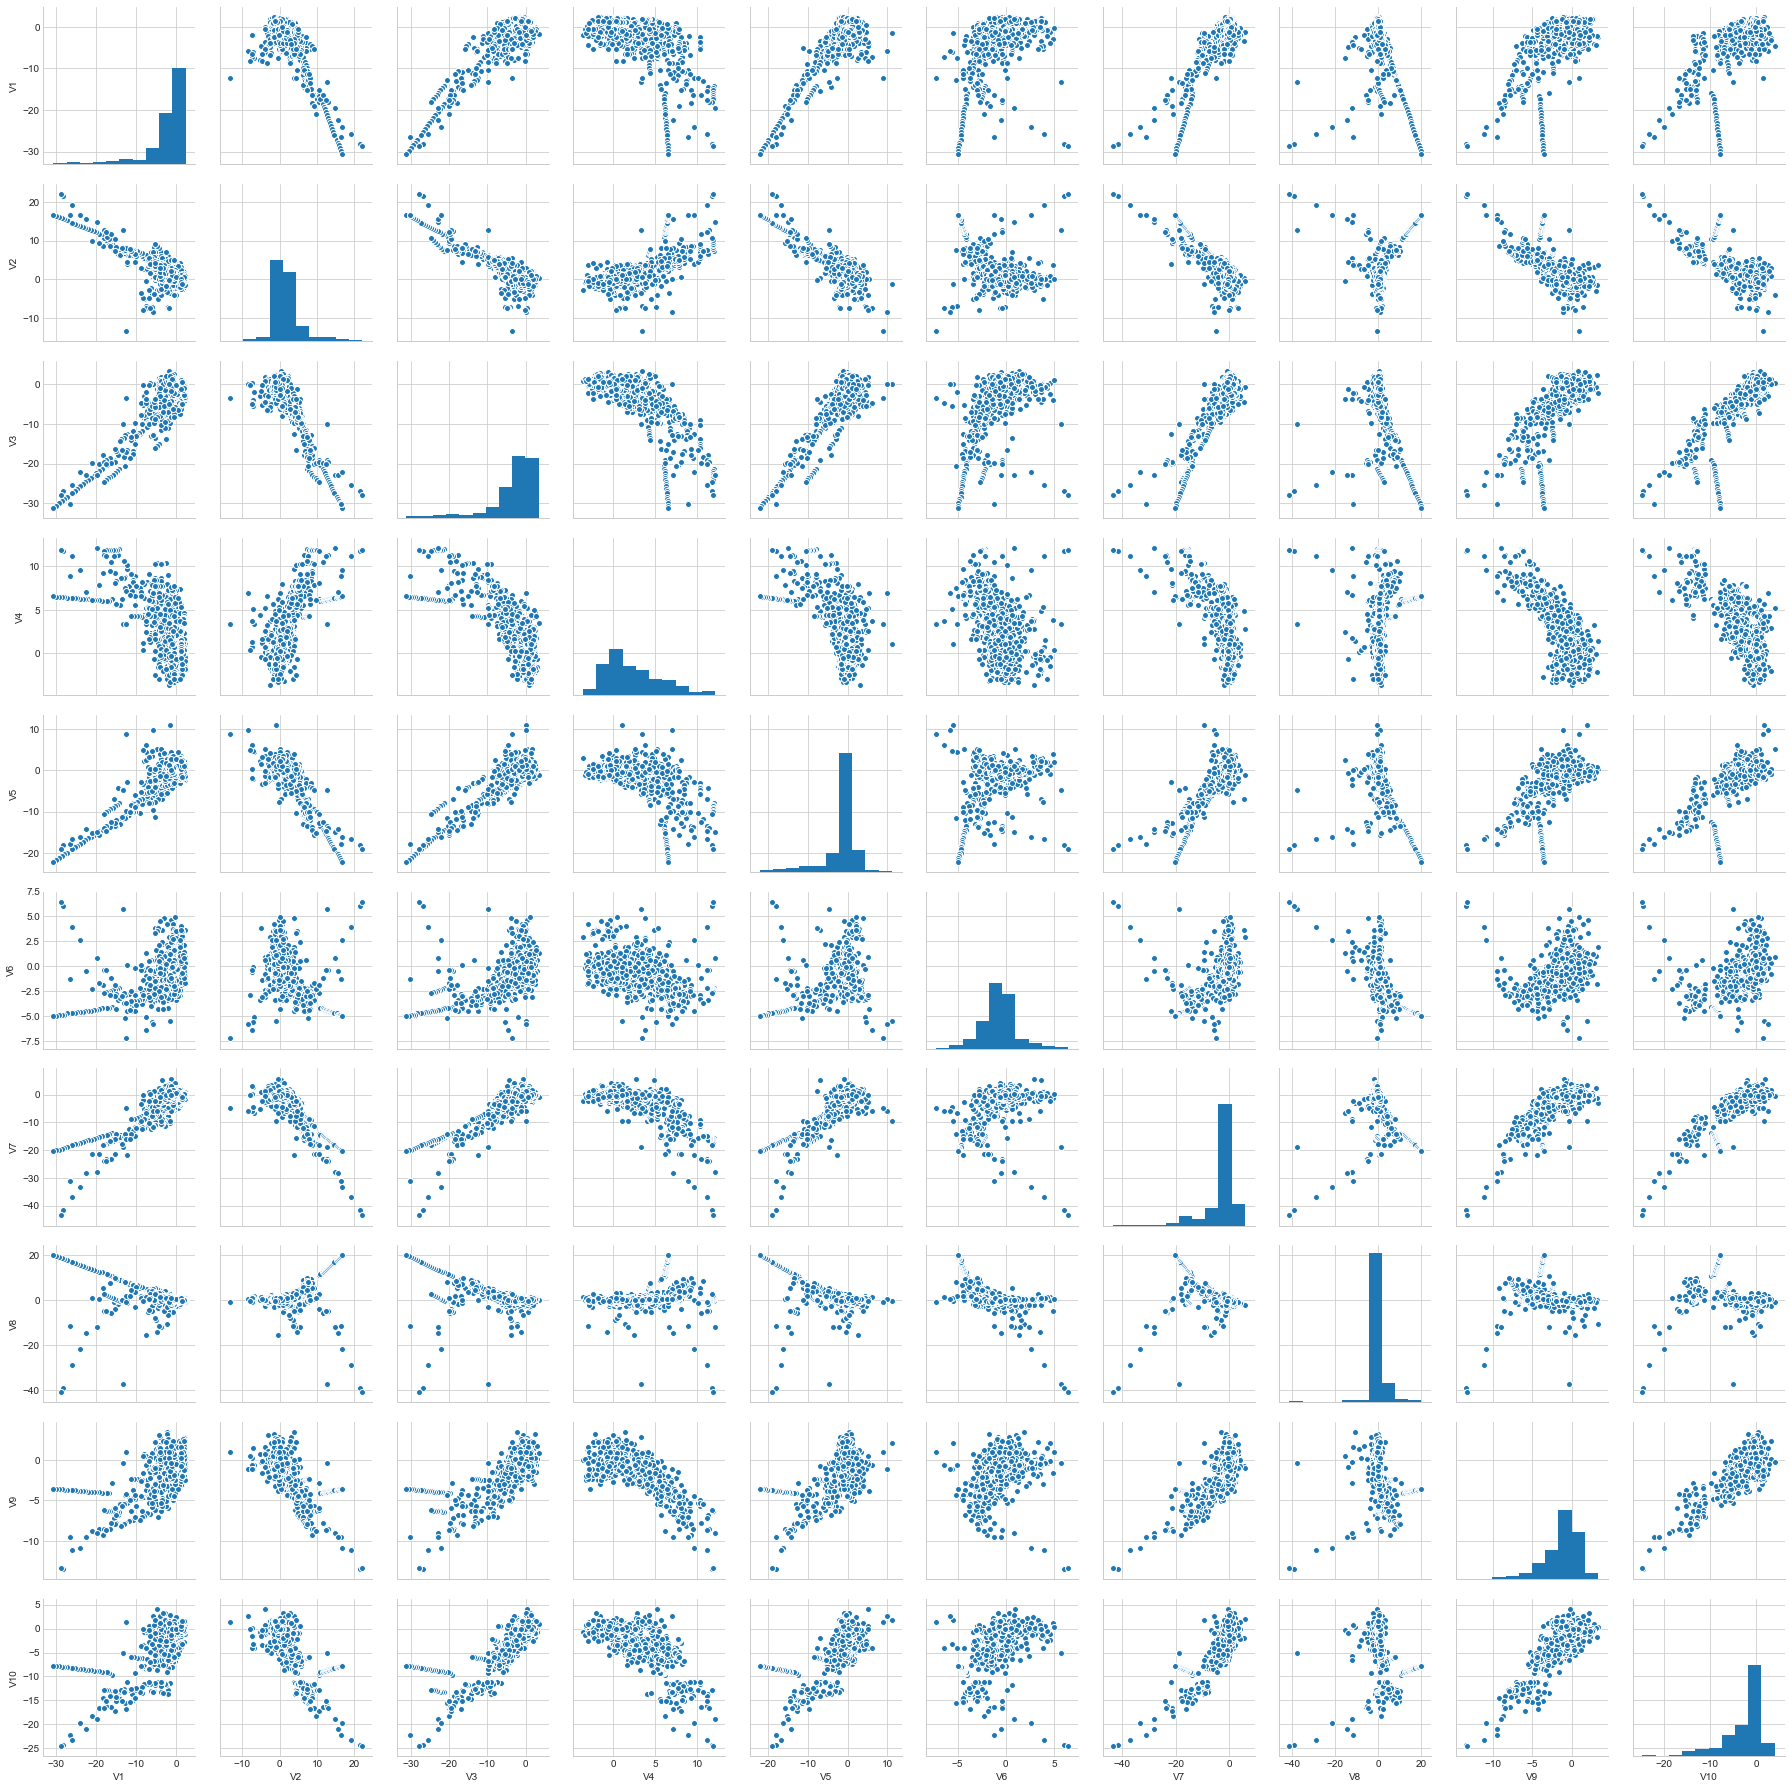

In [188]:
sns.pairplot(undersample_creditcard.iloc[:,range(0,10)])
plt.show()